# 1 - Project setup

## 1.1 - Loading Libraries

In [1]:
# Step One: Loading Packages
# General
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time

# For loading MNIST data in
from mlxtend.data import loadlocal_mnist

# Split Train into train, validation & testing & scoring
# Version of sklearn = 0.20.3
from sklearn.model_selection import train_test_split, validation_curve, cross_val_score, cross_validate,GridSearchCV
import sklearn.metrics as metrics

# sklearn RF ensemble library
from sklearn.ensemble import RandomForestClassifier

# sklearn support vector machine library
from sklearn import svm

# For building CNNS with PyTorch
import torch # Version 1.1.1
from torch import utils, nn
import torch.cuda as cuda
from torch.autograd import Variable
import torch.nn.functional as F

# optimisation and utilisation function for torch
import torch.optim as optim

# Skorch is scikit-learn compatible and wraps PyTorch
from skorch import NeuralNetClassifier # Version 0.5.0.post0

# sklearn preprocessing libraries for normalisation and standardisation
from sklearn.preprocessing import normalize, StandardScaler

# Seaborn to make things look 'pretty'
import seaborn as sns # Version 0.9.0

## 1.2 Declaring functions for later use

In [2]:
# configuring CUDA for offloading data to GPU
def check_set_cuda():

    # Is cuda available on this machine for GPU fun?
    cuda_on = torch.cuda.is_available() 
    out = print("Is CUDA available on your machine? {}".format(torch.cuda.is_available()))

    if cuda_on == True:
        cuda.init()

        # If we're training a CNN, set the device for later CNN work
        if cuda_on == True:        
            print("You're using a : {}".format(cuda.get_device_name(0)))   
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
        device = 'cpu'
    return(device)
        
    
def read_data():    
    # Using loadlocaL_mnist library to load local data files
    # Data can be found at: https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion
    X_train, y_train = loadlocal_mnist(images_path='../Input/train-images-idx3-ubyte', labels_path='../Input/train-labels-idx1-ubyte')
    X_test, y_test = loadlocal_mnist(images_path='../Input/t10k-images-idx3-ubyte', labels_path='../Input/t10k-labels-idx1-ubyte')


    ## Normalise features for test & training
    #if algo != 'svm':
    X_train = X_train.astype('float32')
    X_train = normalize(X_train)
    
    X_test = X_test.astype('float32')    
    X_test = normalize(X_test)    
    
    return (X_train, y_train, X_test, y_test)

def generate_cm(actuals, preds):    
            
    cm = metrics.confusion_matrix(actuals, preds)

    # Generate and plot CM
    fig, ax = plt.subplots(figsize=(8,8)) 
    sns.heatmap(cm, cmap='Greens',annot=True, fmt="d", linewidths=3)    
    
    return(cm)


# 2 - Building a Support Vector Machine Classifier - Polynomial & Radial Basis Function 

## 2.1 - Using Gridsearch with cross-validation to find best fit of parameters against validation

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

X_train, y_train, X_test, y_test = read_data(algo='svm')

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'],  'C': [0.001, 0.10, 0.1, 1, 10]},
                    {'kernel': ['sigmoid'], 'C': [0.001, 0.10, 0.1, 10]},
                    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10]}
                   ]

clf = GridSearchCV(SVC(), tuned_parameters, cv = 3, scoring= 'accuracy', n_jobs=6, verbose=2)

start_time = time.time()

clf.fit(X_train, y_train.ravel())

end_time = time.time()
print("Gridsearching train and test set takes:", end_time - start_time, "seconds")

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

## 2.2 Train the model for SVM - With RBF and C = 10

In [ ]:
start_time = time.time()
# Building a mukti-class SVM
X_train, y_train, X_test, y_test = read_data()

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

svc = svm.SVC(kernel = 'rbf', C = 0.1, gamma = 'scale', max_iter=1500,decision_function_shape = 'ovr',cache_size=4000, random_state=42, verbose=True) #kernel could also be linear, etc..

# Train the model
svc.fit(X_train, y_train)

end_time = time.time()
print("SVM fit time:", end_time - start_time, "seconds")

## 2.3 Carry out cross-validation for scoring (CV=10) of SVC

In [ ]:
start_time = time.time()
# Cross validation on the validation set
scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']

scores = cross_validate(svc, X_validate, y_validate, scoring=scoring,cv=10, n_jobs=-1)

# Carry out predictions for the validation and test set
y_validate_pred = svc.predict(X_validate)
y_pred = svc.predict(X_test)

print("Classification report - Validate")
print(metrics.classification_report(y_validate, y_validate_pred))

print("Classification report - Test")
print(metrics.classification_report(y_test, y_pred))

generate_cm(y_test,y_pred)

end_time = time.time()
print("SVM fit time:", end_time - start_time, "seconds")


## 2.4 Write out the SVC model for later use and submission

In [ ]:
from joblib import dump, load

dump(svc, '../Input/svc_rbf.joblib',compress=True)

# 3 - Convolutional Neural Network - Setup

## 3.1 Reshape data into a 4D tensor to get ready to build a CNN

In [3]:
# If we're training a CNN, set the device for later CNN work
device = check_set_cuda()
    
X_train, y_train, X_test, y_test = read_data()

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

# Reshaping to 4D for later tensor work
X_train = X_train.reshape(-1,1,28,28)
X_test = X_test.reshape(-1,1,28,28)
X_validate = X_validate.reshape(-1,1,28,28)

y_train = torch.tensor(y_train, dtype =torch.long, device = device)
y_validate = torch.tensor(y_validate, dtype =torch.long, device = device)
y_test = torch.tensor(y_test, dtype =torch.long, device = device)


X_train.shape, y_validate.shape, y_train.shape

Is CUDA available on your machine? False


((48000, 1, 28, 28), torch.Size([12000]), torch.Size([48000]))

## 3.2 Create & instantiate the class to build either 2 or 3-layer CNN

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2, stride=1)    
        self.norm1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2,2)
        self.dropout1 = nn.Dropout2d(p=0.25)
       
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2, stride=1)
        self.norm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2,2)        
        self.dropout2 = nn.Dropout(p=0.25)        
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2, stride=1)
        self.norm3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2,2)        
        self.dropout3 = nn.Dropout(p=0.5)        
        
        self.fc1 = nn.Linear(128*3*3, 10) #- 3 Layer CNN                       
        #self.fc1 = nn.Linear(64*7*7, 10) #- 3 Layer CNN               
        
        
    def forward(self, x,**kwargs):        
        # Layer 1
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)                        
        
        # For debugging purposes
        #print(x.shape)
        #x = x.view(-1,7*7*64) #- 2 Layer CNN
        x = x.view(-1,128*3*3) #- 3 Layer CNN            
        #x = x.view(-1,64*7*7) #- 3 Layer CNN            
        
        x = self.fc1(x)                                            
        x = F.softmax(x, dim=-1)
        return x
    

## 3.3 - Training the CNN model, plotting Training Loss/Validation curve + other evaluation metrics

In [14]:
# Instantiate our cnn using Skorch's NeuralNetClassifier function
# We can specify number of max epochs, the learning rate, optimiser, device to be used (CUDA or not)
# Plus imporantly the optimiser and batch_size!

cnn = NeuralNetClassifier(ConvNet,
                          max_epochs=30,
                          lr=0.0005, 
                          optimizer = optim.Adam,
                          device=device, 
                          iterator_train_shuffle = True, 
                          criterion=torch.nn.modules.loss.CrossEntropyLoss,
                          batch_size = 256,
                          warm_start = False
                         )

## 3.4 - Train the model and carry out predictions

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8269       0.8032        1.6683  3.3191
      2        1.6656       0.8259        1.6401  3.3700
      3        1.6472       0.8386        1.6271  3.2882
      4        1.6377       0.8413        1.6235  3.2762
      5        1.6321       0.8434        1.6196  3.3121
      6        1.6280       0.8448        1.6194  3.2912
      7        1.6211       0.8758        1.5880  3.3211
      8        1.5968       0.8896        1.5753  3.2982
      9        1.5880       0.8927        1.5711  3.2912
     10        1.5811       0.9012        1.5642  3.3271
     11        1.5776       0.9042        1.5595  3.2882
     12        1.5723       0.9006        1.5627  3.3002
     13        1.5691       0.9087        1.5553  3.3381
     14        1.5672       0.9098        1.5535  3.3082
     15        1.5655       0.9117        1.5530  3.3500
     16        1.5628       0.9

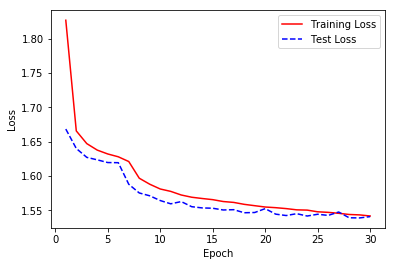

Training - Validation Accuracy
0.9165833333333333
Test Accuracy
0.9089
Test - Recall score
0.9089
Test - Precision
0.910905724202032
All classes
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1000
           1       0.99      0.98      0.98      1000
           2       0.91      0.81      0.86      1000
           3       0.89      0.93      0.91      1000
           4       0.83      0.85      0.84      1000
           5       0.99      0.97      0.98      1000
           6       0.71      0.77      0.74      1000
           7       0.96      0.97      0.96      1000
           8       0.99      0.98      0.98      1000
           9       0.97      0.97      0.97      1000

   micro avg       0.91      0.91      0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



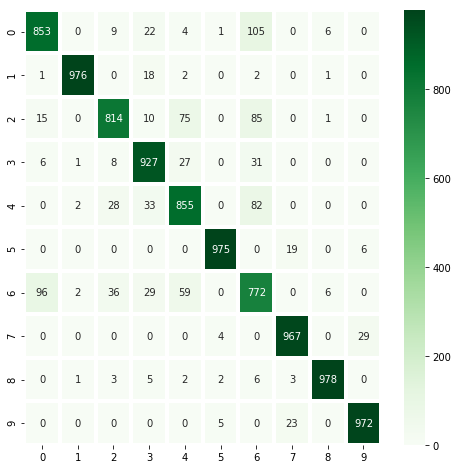

In [15]:
# Manually setting the seed for reproducibility
torch.manual_seed(42)

#Time to train, and store our results in the history object for later plotting
history = cnn.fit(X_train,y_train)

# Get the history of the last CNN run
plot_history = cnn.history
epoch_count = range(1,cnn.max_epochs+1)
train_losses = plot_history[:, 'train_loss']
val_losses = plot_history[:, 'valid_loss']


# Visualize loss history
plt.plot(epoch_count, train_losses, 'r-')
plt.plot(epoch_count, val_losses, 'b--')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

# Declare our empty lists for the predictions and test predictions
preds = []
preds_test = []

# Create the predictions
preds = cnn.predict(X_validate)
preds_test = cnn.predict(X_test)

# Bring the tensor back to CPU for sklearn accuracy stuff - Validation set
y_validate_cpu = y_validate.cpu()
y_validate_np = y_validate_cpu.numpy()

# Bring the tensor back to CPU for sklearn accuracy stuff - Test set
y_test_cpu = y_test.cpu()
y_test_np = y_test_cpu.numpy()

# Using the helper function to generate a confusion matrix
generate_cm(y_test_np, preds_test)


print("Training - Validation Accuracy")
print(metrics.accuracy_score(y_validate_np, preds))

print("Test Accuracy")
print(metrics.accuracy_score(y_test_np, preds_test))

print("Test - Recall score")
print(metrics.recall_score(y_test_np, preds_test,average='macro'))

print("Test - Precision")
print(metrics.precision_score(y_test_np, preds_test, average='macro'))

print("All classes")
print(metrics.classification_report(y_test_np, preds_test))

## 3.5 Saving out our CNN to disk to re-use

In [16]:
from joblib import dump, load

dump(cnn, '../Input/cnn.joblib')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


['../Input/cnn.joblib']

# 5 - Creating RandomForest Classifiers

## 5.1 - Applying GridSearch (with Cross Validation) to obtain the 'best' parameters for RF

In [ ]:
%%time
model = RandomForestClassifier(random_state=42, n_jobs=-1) #n_jobs to use all processors 

X_train, y_train, X_test, y_test = read_data()

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

param_grid = { 
    'n_estimators': [100,125, 150, 175, 200],    
    'max_features': ['auto'],
    'max_depth' : [30,40,50,100,150,200],
    'criterion' :['gini', 'entropy']
}

CV_rf = GridSearchCV(estimator=model, param_grid=param_grid, cv= 3, verbose=2)
CV_rf.fit(X_train, y_train)

print(CV_rf.best_params_)

## 5.2 - Building out the RF with the best model parameters from GridSearchCV above 

In [ ]:
start_time = time.time()

# Read data in 
X_train, y_train, X_test, y_test = read_data()

# Split data out
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
    
# Using best parameters from previous Gridsearch build RF classifier    
rf = RandomForestClassifier(criterion='entropy',max_depth=100, max_features='auto',n_estimators=200, n_jobs=-1) 
rf.fit(X_train, y_train.ravel())
end_time = time.time()

print("RF fit time:", end_time - start_time, "seconds")

## 5.3 Carry out cross-validation (CV=10) for RF

In [ ]:
y_pred_test = rf.predict(X_test)
y_pred_test.shape
#print(metrics.accuracy_score(y_test, y_pred_test))
scores = cross_val_score(estimator=rf, cv=10, X=X_validate, y=y_validate, scoring='accuracy', n_jobs=-1)
np.average(scores)

## 5.4 - Saving out our RF to disk for later use in the 'master_tuned_models.ipynb'

In [ ]:
from joblib import dump, load

dump(rf, '../Input/rf.joblib',compress=True)

In [ ]:
start_time = time.time()
# Cross validation on the validation set
scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']

scores = cross_validate(svc, X_validate, y_validate, scoring=scoring,cv=10, n_jobs=-1)

# Carry out predictions for the validation and test set
y_validate_pred = svc.predict(X_validate)
y_pred = svc.predict(X_test)

print("Classification report - Validate")
print(metrics.classification_report(y_validate, y_validate_pred))

print("Classification report - Test")
print(metrics.classification_report(y_test, y_pred))

generate_cm(y_test,y_pred)

end_time = time.time()
print("SVM fit time:", end_time - start_time, "seconds")
